In [33]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import yfinance as yf

# Download AAPL historical data
df = yf.download('AAPL', start='2023-01-01', end='2025-05-24')


[*********************100%***********************]  1 of 1 completed


In [34]:
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))


In [70]:
window = 16
threshold = 2.7
df['Rolling_Mean'] = df['Log_Return'].rolling(window).mean()
df['Rolling_STD'] = df['Log_Return'].rolling(window).std()
df['Z_Score'] = (df['Log_Return'] - df['Rolling_Mean']) / df['Rolling_STD']
df['Anomaly'] = (df['Z_Score'] > threshold) | (df['Z_Score'] < -threshold)

In [71]:
df['Z_Score'] = (df['Log_Return'] - df['Rolling_Mean']) / df['Rolling_STD']
threshold = 2.7
df['Anomaly'] = (df['Z_Score'] > threshold) | (df['Z_Score'] < -threshold)


In [72]:
df['Anomaly'].value_counts()

Anomaly
False    590
True      10
Name: count, dtype: int64

In [73]:
df.loc[df['Anomaly'] == True]

Price,Close,High,Low,Open,Volume,Log_Return,Rolling_Mean,Rolling_STD,Z_Score,Anomaly
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,
Date,,,,,,,,,,
2023-05-05,171.612030,172.333791,168.833716,169.051235,113316400,0.045859,0.002953,0.014871,2.885236,True
2023-08-04,180.185928,185.522496,180.116615,183.680934,115799700,-0.049211,-0.002869,0.015024,-3.084467,True
2024-01-02,184.290436,187.070083,182.553158,185.789453,82488700,-0.036443,-0.002840,0.011716,-2.868004,True
2024-05-03,182.279175,185.877439,181.563496,185.529534,163224100,0.058096,0.002909,0.020238,2.726826,True
2024-06-11,206.185730,206.195693,192.728675,192.748571,172373300,0.070131,0.005444,0.020148,3.210616,True
2024-09-03,221.989670,228.197843,220.395268,227.749422,50190600,-0.027582,0.001932,0.010729,-2.750800,True
2024-12-18,247.453079,253.668083,247.143828,251.553189,56774100,-0.021655,0.003947,0.009052,-2.828368,True
2025-03-10,227.182083,235.850724,223.926358,235.231525,72071200,-0.049694,-0.003746,0.016974,-2.707063,True


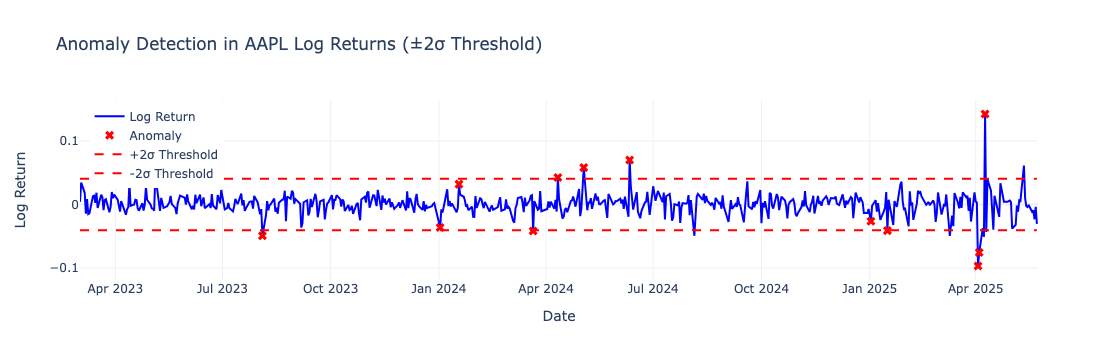

In [69]:
# Clean data by dropping NaN values
df_clean = df.dropna()

# Create Plotly figure
fig = go.Figure()

# Plot Log Returns
fig.add_trace(go.Scatter(
    x=df_clean.index, y=df_clean['Log_Return'],
    mode='lines', name='Log Return', line=dict(color='blue')
))

# Plot Anomalies
fig.add_trace(go.Scatter(
    x=df_clean.loc[df_clean['Anomaly'], 'Log_Return'].index,
    y=df_clean.loc[df_clean['Anomaly'], 'Log_Return'],
    mode='markers',
    name='Anomaly',
    marker=dict(color='red', size=8, symbol='x')
))

# Plot Threshold Lines
fig.add_trace(go.Scatter(
    x=df_clean.index,
    y=[threshold * df_clean['Rolling_STD'].mean()] * len(df_clean),
    mode='lines',
    name='+2σ Threshold',
    line=dict(color='red', dash='dash')
))

fig.add_trace(go.Scatter(
    x=df_clean.index,
    y=[-threshold * df_clean['Rolling_STD'].mean()] * len(df_clean),
    mode='lines',
    name='-2σ Threshold',
    line=dict(color='red', dash='dash')
))

# Update Layout
fig.update_layout(
    title='Anomaly Detection in AAPL Log Returns (±2σ Threshold)',
    xaxis_title='Date',
    yaxis_title='Log Return',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    hovermode='x unified'
)

fig.show()


[*********************100%***********************]  1 of 1 completed


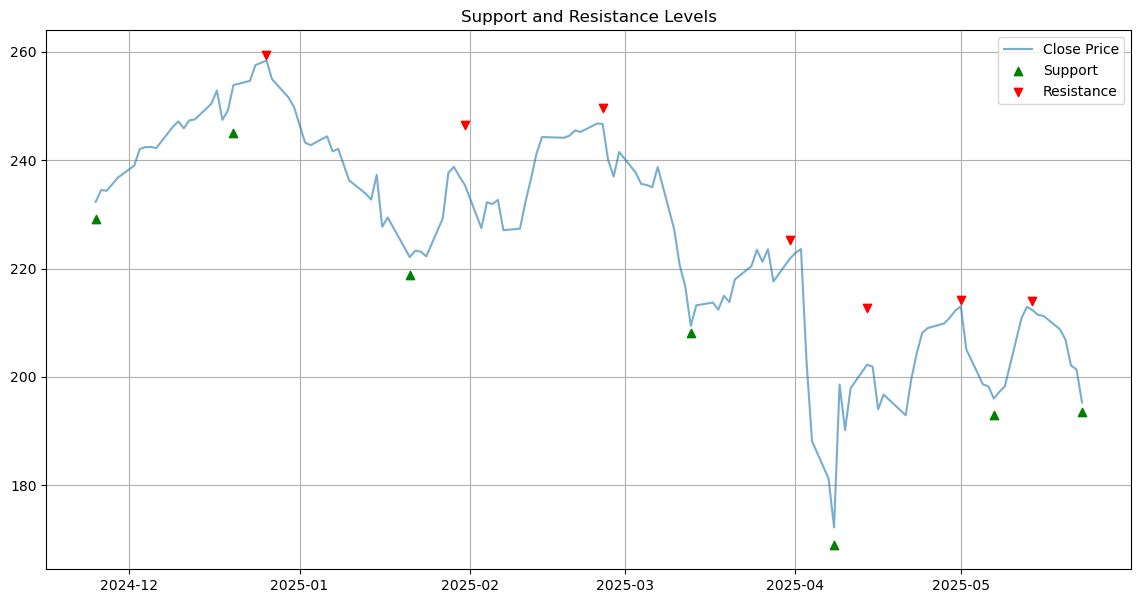

In [74]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

def fetch_stock_data(symbol, period='6mo', interval='1d'):
    data = yf.download(symbol, period=period, interval=interval)
    return data

def get_support_resistance_levels(data, order=5):
    # Local minima as support
    support_idx = argrelextrema(data['Low'].values, np.less_equal, order=order)[0]
    support_levels = data['Low'].iloc[support_idx]

    # Local maxima as resistance
    resistance_idx = argrelextrema(data['High'].values, np.greater_equal, order=order)[0]
    resistance_levels = data['High'].iloc[resistance_idx]

    return support_levels, resistance_levels

def plot_support_resistance(data, support_levels, resistance_levels):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Close Price', alpha=0.6)
    plt.scatter(support_levels.index, support_levels.values, marker='^', color='green', label='Support', zorder=5)
    plt.scatter(resistance_levels.index, resistance_levels.values, marker='v', color='red', label='Resistance', zorder=5)
    plt.title('Support and Resistance Levels')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage
symbol = 'AAPL'  # Replace with your stock symbol
data = fetch_stock_data(symbol)
support_levels, resistance_levels = get_support_resistance_levels(data)
plot_support_resistance(data, support_levels, resistance_levels)


In [83]:
# Use arch package
from arch import arch_model
returns = data['LogReturns'].dropna() * 100
model = arch_model(returns, vol='Garch', p=1, q=1)
res = model.fit()
print(res.summary())


Iteration:      1,   Func. Count:      6,   Neg. LLF: 461.32684986273017
Iteration:      2,   Func. Count:     13,   Neg. LLF: 311.0666153784977
Iteration:      3,   Func. Count:     19,   Neg. LLF: 305.94928841708963
Iteration:      4,   Func. Count:     26,   Neg. LLF: 520.6693697478806
Iteration:      5,   Func. Count:     32,   Neg. LLF: 271.29679200018535
Iteration:      6,   Func. Count:     38,   Neg. LLF: 270.18493829035594
Iteration:      7,   Func. Count:     43,   Neg. LLF: 270.18467535366415
Iteration:      8,   Func. Count:     48,   Neg. LLF: 270.1846623056489
Iteration:      9,   Func. Count:     53,   Neg. LLF: 270.18466173305103
Optimization terminated successfully    (Exit mode 0)
            Current function value: 270.18466173305103
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             LogReturns   R-squared:         

[*********************100%***********************]  1 of 1 completed


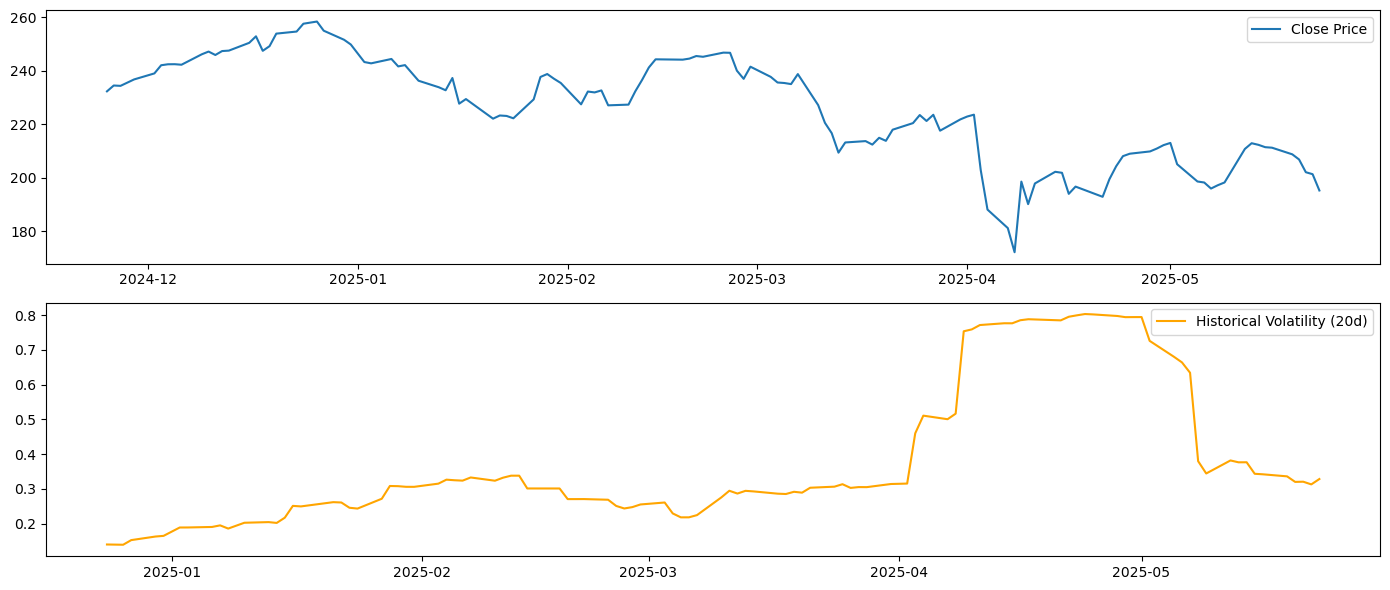

In [82]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

def get_historical_volatility(symbol, window=20):
    data = yf.download(symbol, period='6mo', interval='1d')
    data['LogReturns'] = np.log(data['Close'] / data['Close'].shift(1))
    
    # Rolling standard deviation of log returns
    data['Volatility'] = data['LogReturns'].rolling(window).std() * np.sqrt(252)  # Annualize
    
    return data[['Close', 'Volatility','LogReturns']]

# Example
symbol = 'AAPL'
data = get_historical_volatility(symbol)

# Plot
plt.figure(figsize=(14, 6))
plt.subplot(2,1,1)
plt.plot(data['Close'], label='Close Price')
plt.legend()

plt.subplot(2,1,2)
plt.plot(data['Volatility'], color='orange', label='Historical Volatility (20d)')
plt.legend()
plt.tight_layout()
plt.show()


In [77]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 946.4/946.4 kB 2.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  1 of 1 completed

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -506.410
Distribution:                  Normal   AIC:                           1020.82
Method:            Maximum Likelihood   BIC:                           1034.89
                                        No. Observations:                  249
Date:                Sun, May 25 2025   Df Residuals:                      248
Time:                        15:00:25   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0401      0.122      0.328      0.743 [ -0.200,  0.28

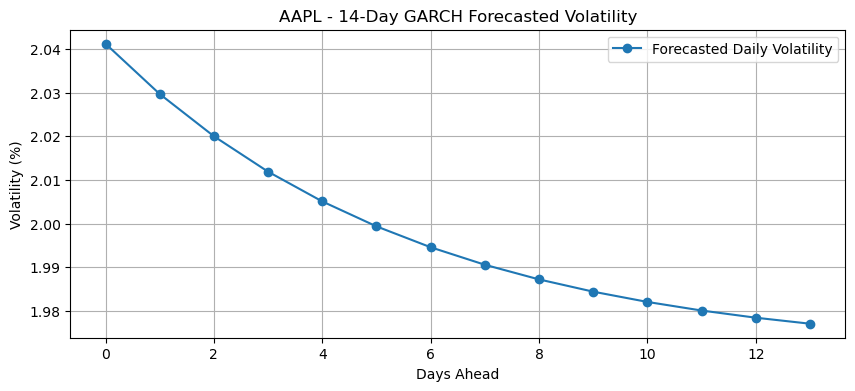

In [84]:
import yfinance as yf
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt

# Step 1: Download historical data
symbol = 'AAPL'
data = yf.download(symbol, period='1y')
returns = 100 * np.log(data['Close'] / data['Close'].shift(1)).dropna()  # % log returns

# Step 2: Fit GARCH(1,1)
model = arch_model(returns, vol='Garch', p=1, q=1)
res = model.fit(disp='off')
print(res.summary())

# Step 3: Forecast 14 days ahead
forecast_horizon = 14
forecast = res.forecast(horizon=forecast_horizon)

# Step 4: Extract daily conditional variance forecast
variance_forecast = forecast.variance.values[-1, :]
volatility_forecast = np.sqrt(variance_forecast)  # daily % volatility forecast

# Step 5: Aggregate to get total 14-day volatility (annualized)
total_vol_14d = np.sqrt(np.sum(variance_forecast))  # not annualized
annualized_vol_14d = total_vol_14d * np.sqrt(252 / forecast_horizon)

# Output
print("\n--- 14-Day Volatility Forecast ---")
print(f"Daily forecasted vol (%):\n{volatility_forecast.round(4)}")
print(f"\nTotal 14-day volatility: {total_vol_14d:.4f}%")
print(f"Annualized 14-day volatility: {annualized_vol_14d:.4f}%")

# Optional: Plot
plt.figure(figsize=(10, 4))
plt.plot(volatility_forecast, marker='o', label='Forecasted Daily Volatility')
plt.title(f"{symbol} - 14-Day GARCH Forecasted Volatility")
plt.xlabel("Days Ahead")
plt.ylabel("Volatility (%)")
plt.grid(True)
plt.legend()
plt.show()


In [127]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download 1-minute intraday data
symbol = "AAPL"
data = yf.download(symbol, interval='1m', period='1d', multi_level_index=False)

# Step 1: Calculate Typical Price (Series)
data['TP'] = (data['High'] + data['Low'] + data['Close']) / 3

# Step 2: Cumulative volume and cumulative price*volume
data['cum_vol'] = data['Volume'].cumsum()

data['cum_pv'] = (data['TP'] * data['Volume']).cumsum()
# data['cum_pv'] = np.multiply(data['TP'].values, data['Volume'].values).cumsum()
# Step 3: VWAP
data['VWAP'] = data['cum_pv'] / data['cum_vol']



[*********************100%***********************]  1 of 1 completed


In [128]:
data

,Close,High,Low,Open,Volume,TP,cum_vol,cum_pv,VWAP
Datetime,,,,,,,,,
2025-05-23 13:30:00+00:00,195.384995,196.220001,193.460007,193.664993,8294792,195.021667,8294792,1.617664e+09,195.021667
2025-05-23 13:31:00+00:00,195.720001,196.475006,195.589996,195.779999,810703,195.928335,9105495,1.776504e+09,195.102392
2025-05-23 13:32:00+00:00,195.824997,196.059998,195.507507,195.794998,734901,195.797501,9840396,1.920396e+09,195.154304
2025-05-23 13:33:00+00:00,196.570007,196.740005,195.610001,195.830002,640558,196.306671,10480954,2.046141e+09,195.224733
2025-05-23 13:34:00+00:00,196.509995,196.669998,196.017899,196.540100,422567,196.399297,10903521,2.129133e+09,195.270253
...,...,...,...,...,...,...,...,...,...
2025-05-23 19:55:00+00:00,195.279999,195.360001,195.029999,195.320007,457306,195.223333,67572634,1.324334e+10,195.986787
2025-05-23 19:56:00+00:00,195.511307,195.630005,195.259995,195.284393,429961,195.467102,68002595,1.332739e+10,195.983501
2025-05-23 19:57:00+00:00,195.404999,195.520004,195.320007,195.520004,462225,195.415003,68464820,1.341771e+10,195.979663


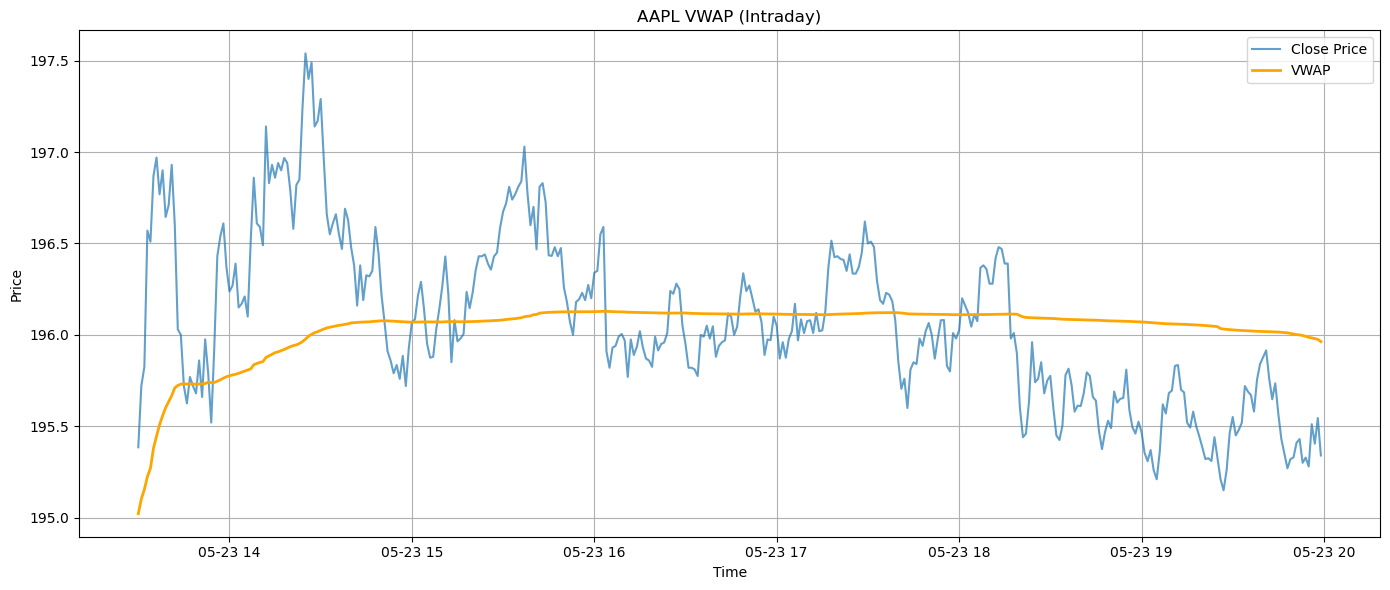

In [129]:

# Plot
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Close Price', alpha=0.7)
plt.plot(data['VWAP'], label='VWAP', color='orange', linewidth=2)
plt.title(f'{symbol} VWAP (Intraday)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
